<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">Table of content</div>

1) **Choice of Metrics**  
2) **Library import & Dataset**  
3.1) **Feature generation**  
3.2) **Data cleaning**              
3.3) **Data scaling (Normalization | Standartization)**  
4) **Dimensionality reduction**  
5) **Clustering**  
6) **Business Recommendations**  

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">1) Choice of Metrics  </div>

There are various metrics for clustering, for example:
* Silhouette coefficient  (https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)
* Calinski-Harabasz Index (https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index)
* Davies-Bouldin Index (https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index)

In this work, in order to evaluate the quality of clustering, we will use the Silhouette coefficient metric as well as after dimensionality reduction, we will look at the data in three-dimensional space for a visual assessment of the quality of clustering. 

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">2) Library import & Dataset </div>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from datetime import datetime
import warnings
import sys
import os

In [4]:
df = pd.read_csv('Mall_Customers.csv', sep=',')

In [5]:
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
print(f'Dataset size: {df.shape}')

Dataset size: (200, 5)


<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">3.1) Feature generation  </div>

# Let's look at EDA:
______________________________________________________________________________________________________________

In [ ]:
df.drop(columns=["CustomerID"], inplace=True )


In [18]:
df.columns
df["Gender"] = df["Gender"].map({
    "Female":0,
    "Male":1
})

## First, let's look at the correlation matrix:

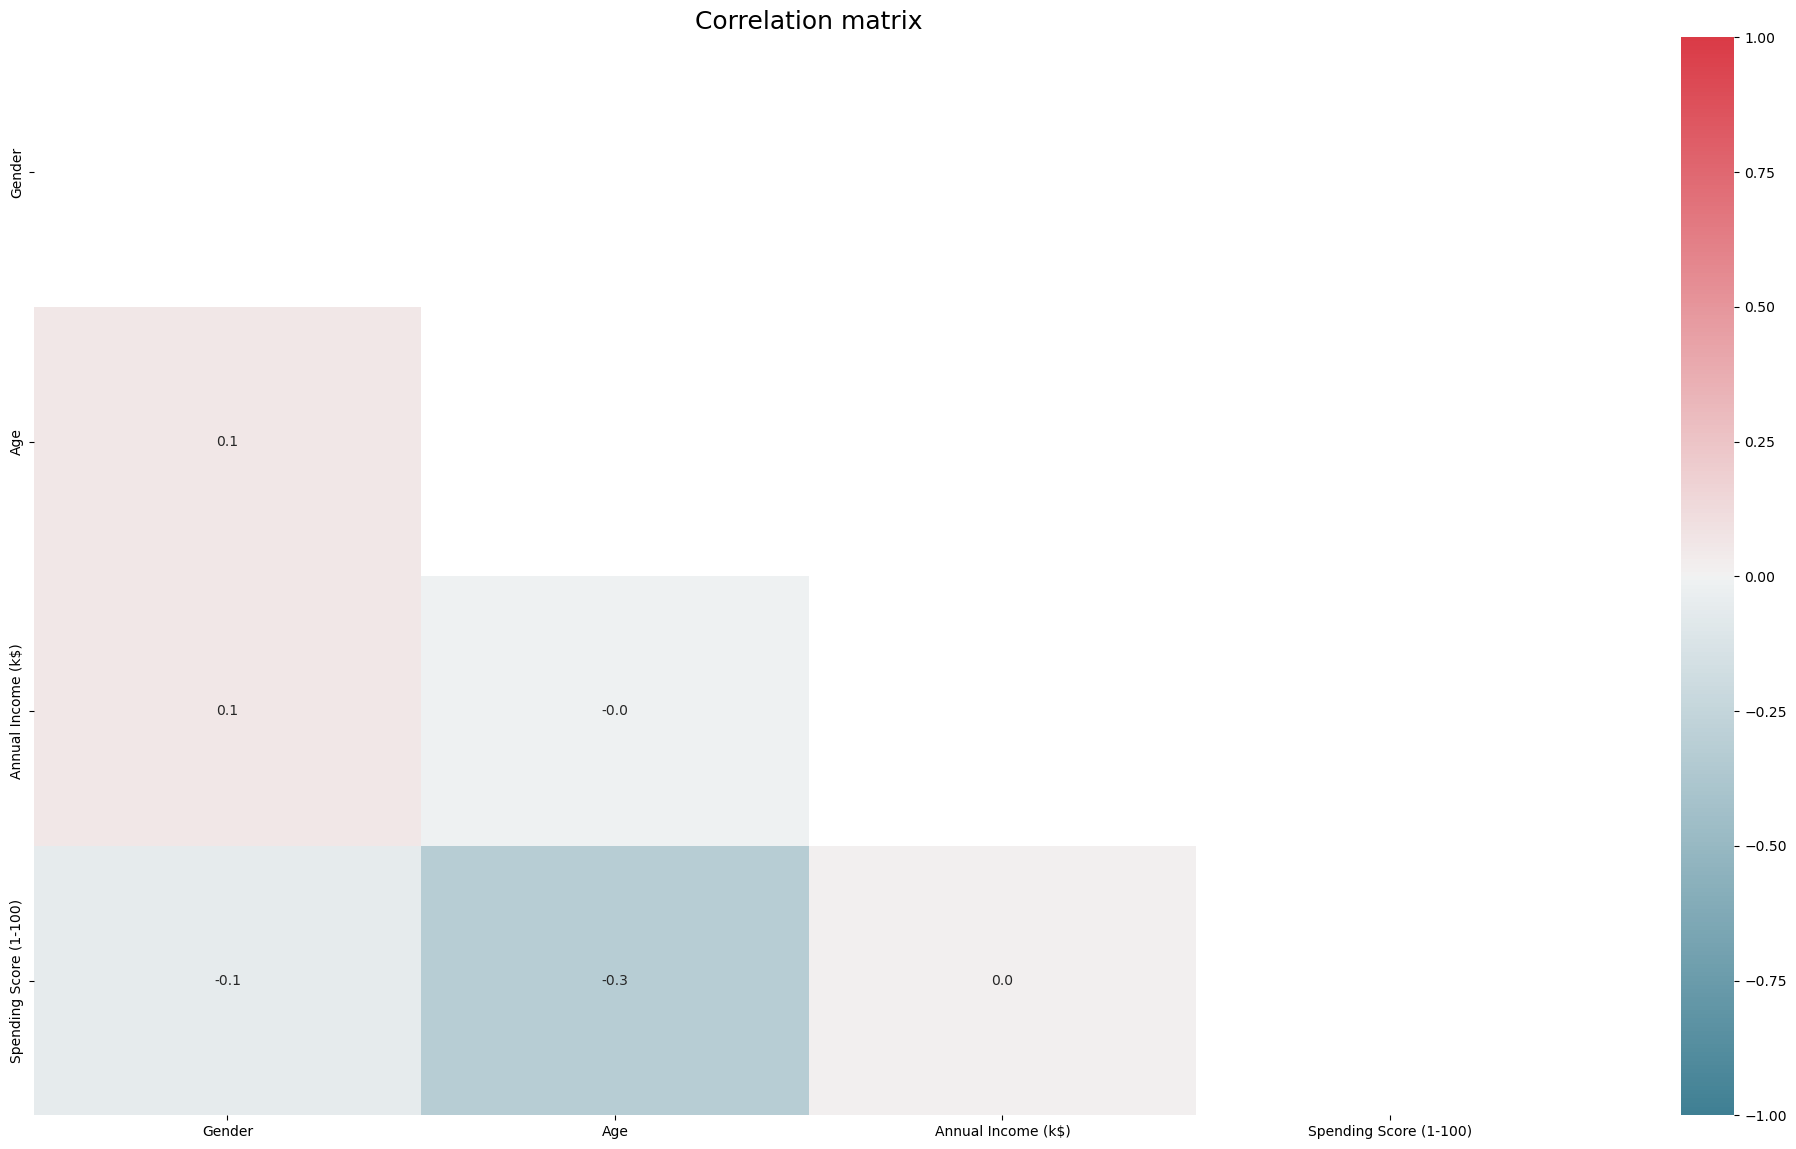

In [20]:
to_corr = ["Gender", 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

cmap = sns.diverging_palette(220, 10, as_cmap=True)
matrix = np.triu(df[to_corr].corr())
plt.figure(figsize=(25, 14))
plt.title('Correlation matrix', fontsize=18)
sns.heatmap(df[to_corr].corr(), annot=True,
            fmt='.1f', vmin=-1, vmax=1, center=0, cmap=cmap, mask=matrix)

plt.show()

## Next, look at the distributions of quantitative variables:

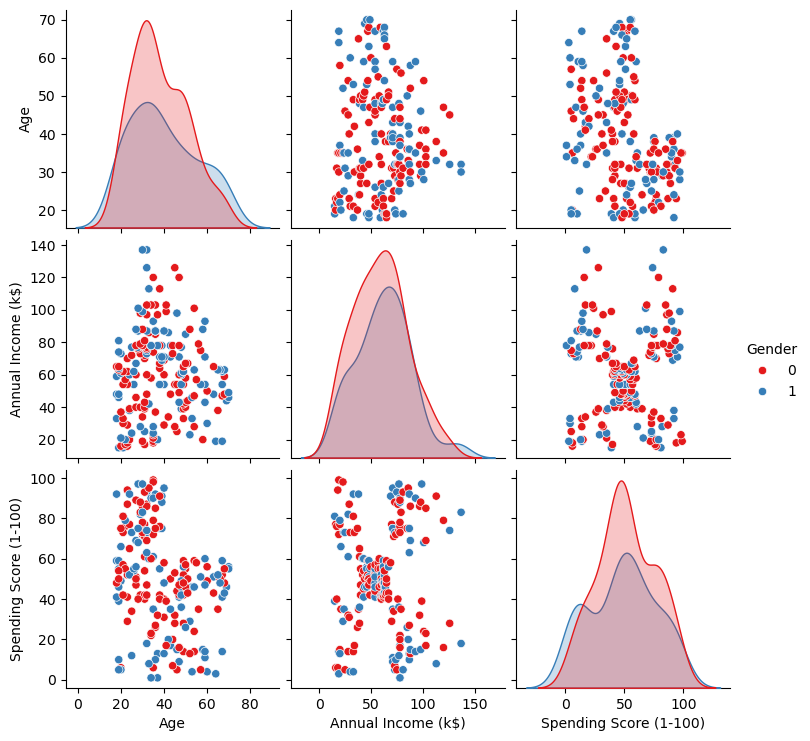

In [22]:
to_plot = ["Gender", 'Age', 'Annual Income (k$)', 'Spending Score (1-100)' ]
sns.pairplot(df[to_plot], hue='Gender', palette='Set1')
plt.show()

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">3.2) Data cleaning </div>

## Remove gaps in the data:

In [23]:
df.isna().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [24]:
df.dropna(inplace=True)  # Removed objects with gaps in income

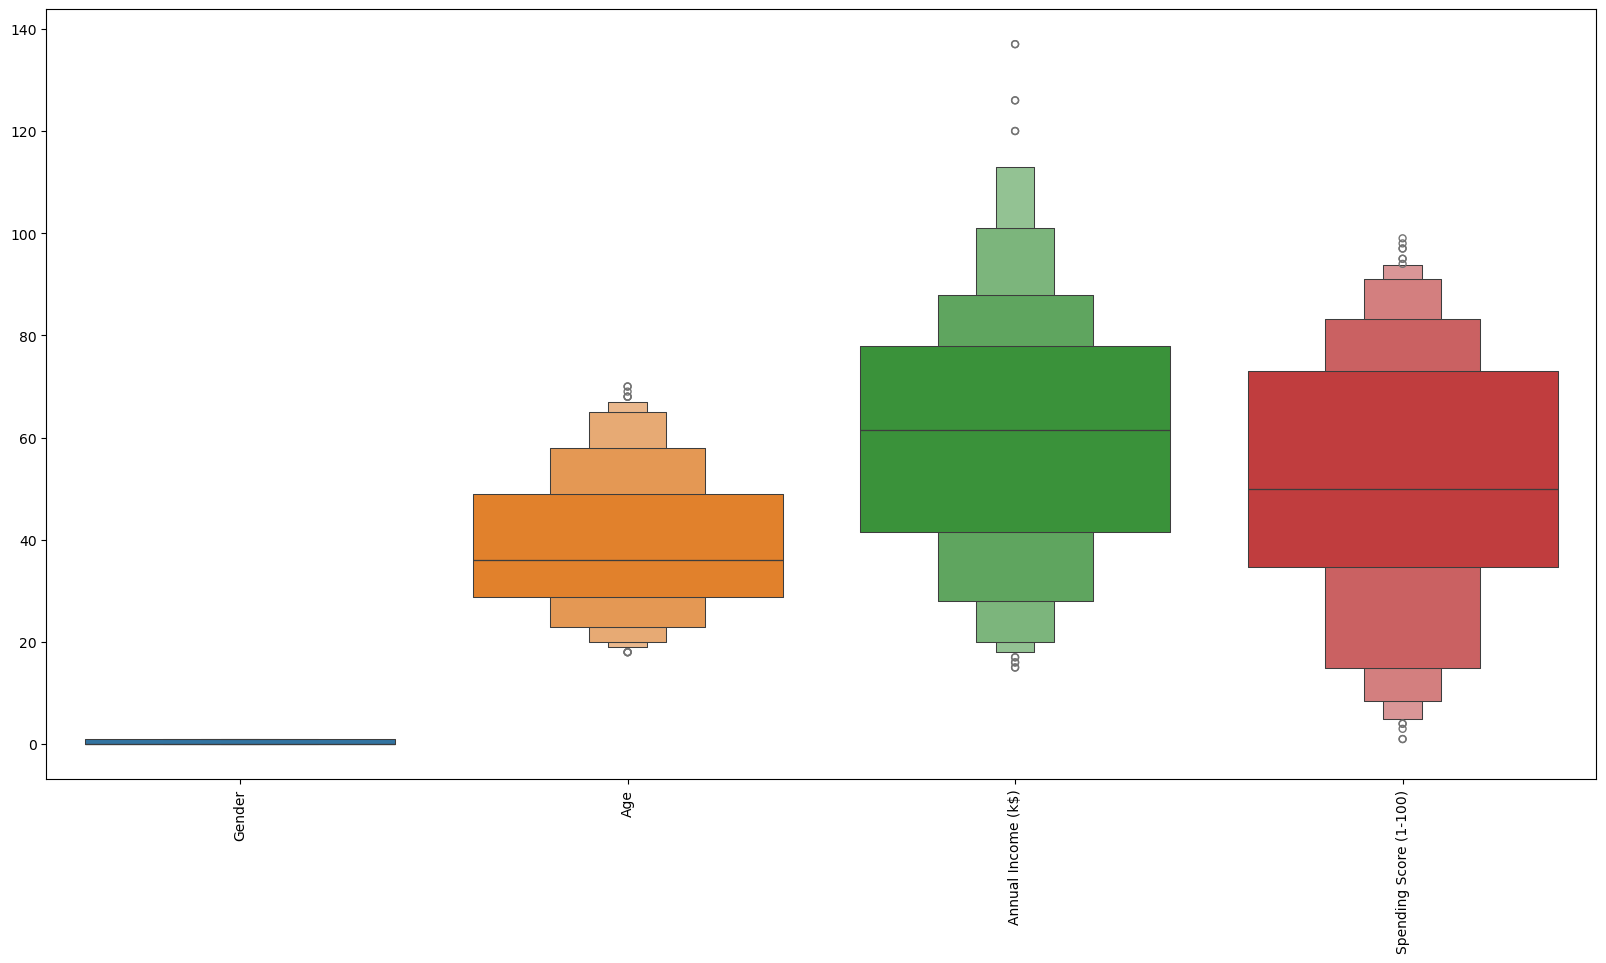

In [26]:
# Prepairing attributes of scale data

plt.figure(figsize=(20,10))
sns.boxenplot(data = df)
plt.xticks(rotation=90)
plt.show()

## Remove outliers in the data:

In [27]:
def remove_outliers(data: pd.DataFrame, column: str):
    q3, q1 = np.nanpercentile(data[column], [75, 25])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]

    return data
df = remove_outliers(df, 'Annual Income (k$)')
df = remove_outliers(df, 'Spending Score (1-100)')

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">3.3) Data scaling (Normalization | Standartization)  </div>

Data scaling is necessary to bring all features to the same scale. If this is not done, then the attention of the algorithm will be attracted to features that include large values (this is bad)  
In this work, normalization will be used as data scaling (as a result of normalization, all features are in the range from 0 to 1)

In [28]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled 

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,0.019231,0.000000,0.387755
1,1.0,0.057692,0.000000,0.816327
2,0.0,0.038462,0.009009,0.051020
3,0.0,0.096154,0.009009,0.775510
4,0.0,0.250000,0.018018,0.397959
...,...,...,...,...
193,0.0,0.384615,0.882883,0.918367
194,0.0,0.557692,0.945946,0.153061
195,0.0,0.326923,0.945946,0.795918
196,0.0,0.519231,1.000000,0.275510


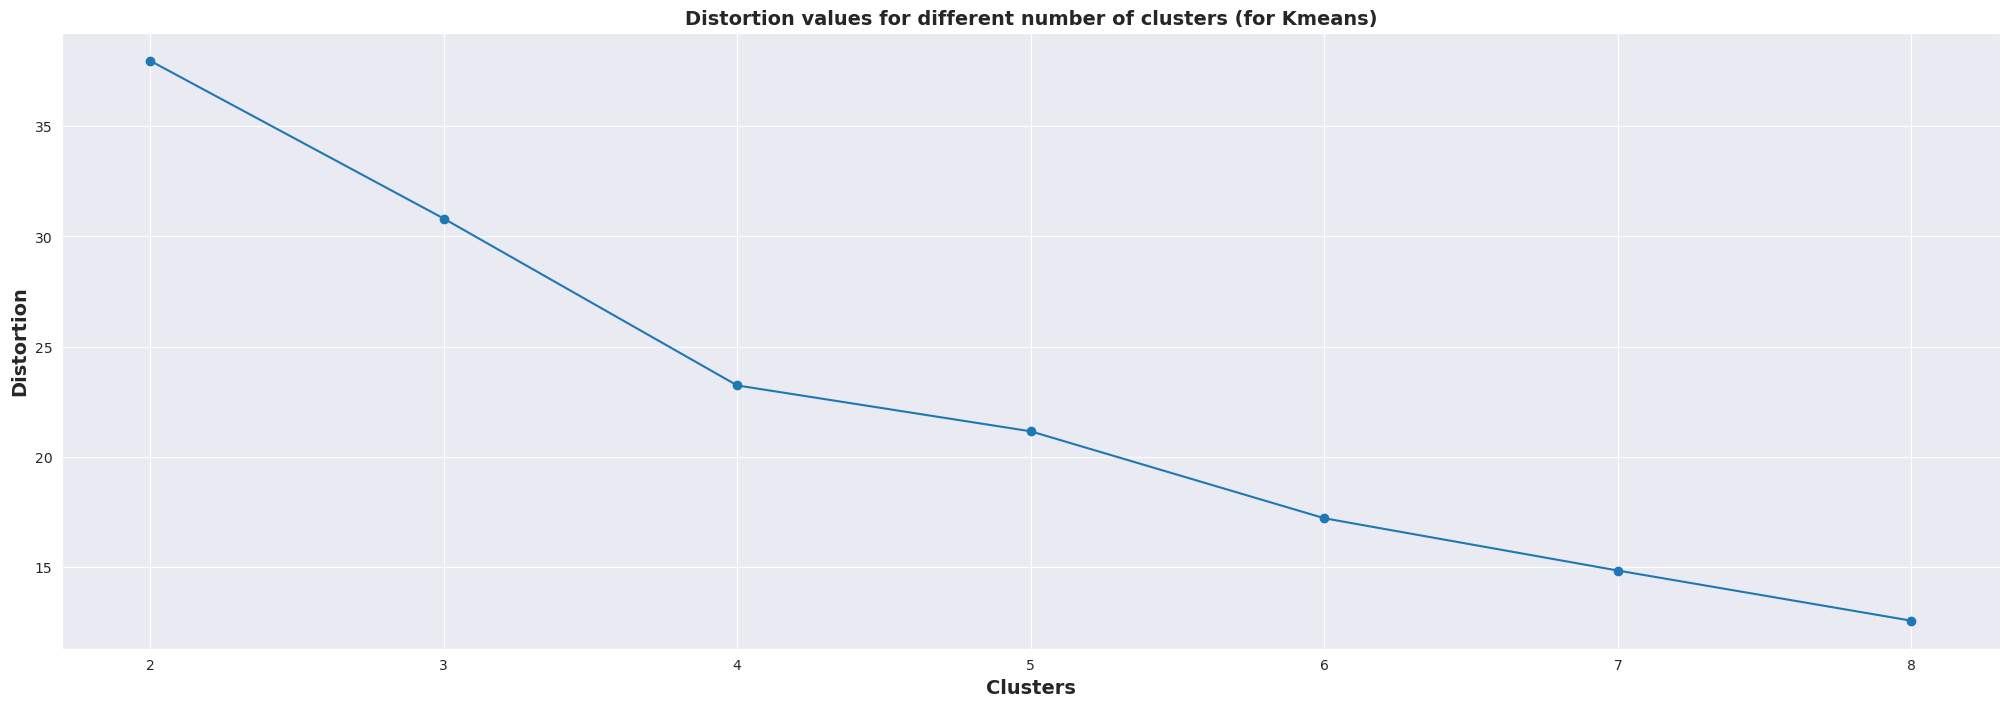

In [29]:
KMeans = KMeans()
inertia = []
for n_clusters in range(2, 9):
    KMeans.set_params(n_clusters=n_clusters)
    KMeans.fit(df_scaled)
    inertia.append(KMeans.inertia_)
    
plt.figure(figsize=(25, 8))
sns.set_style("darkgrid")
plt.title('Distortion values for different number of clusters (for Kmeans)', fontsize=14, fontweight='bold')
plt.xlabel('Clusters', fontsize=14, fontweight='bold')
plt.ylabel('Distortion', fontsize=14, fontweight='bold')
plt.plot(range(2, 9), inertia, marker='o')
plt.show()

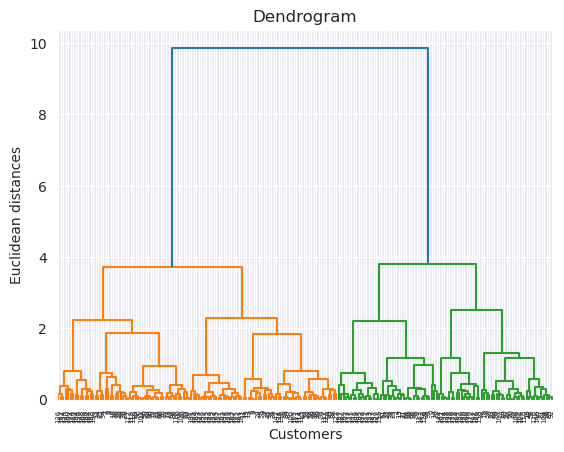

In [30]:
# Dendrogram

import scipy.cluster.hierarchy as shc

dendrogram = shc.dendrogram(shc.linkage(df_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">4) Dimensionality reduction  </div>

The dimensionality reduction problem is used in the following situations:
* There are a lot of features in the dataset, and we want to reduce their number, leaving as much information as possible
* We have many features in the dataset, and we want to visualize the data (for example, in 3D space)
* Solving the problem of multicollinearity

There are many different options for dimensionality reduction, which are based on different methods, for example:
* Principal component analysis (PCA)
* Uniform Manifold Approximation and Projection (UMAP)
* t-distributed Stochastic Neighbor Embedding (t-SNE)
* Locally-Linear Embedding (LLE)
* Multidimensional Scaling (MDS)

The most commonly used dimensionality reduction algorithm is PCA, and we also use it in this work.  
Essentially, in PCA we make a transition from one variable space to another, with the new space containing fewer variables (n_component), where the new variables are uncorrelated and are the weighted sum of the old variables.  
As a result we get m variables: {PC1, PC2, PC3... PCm} , where PC1 will receive the most information(maximum sample variance), PC2 - less, and so on (A variable is considered informative if it has a high sample variance).  
8 components will be used in this work.

In [31]:
def dim_reduction(data: pd.DataFrame,n_components = 2) -> pd.DataFrame:
    pca = PCA(n_components=n_components, random_state=42)
    data = pd.DataFrame(pca.fit_transform(data), columns =([f'PC{i}' for i in range(1, n_components + 1)]))
    return data

df_transform = dim_reduction(df_scaled)  # df: scaling + dimensionality reduction
df_transform.index = df_scaled.index  # for convenient work with dataframes

In [32]:
df_transform

,PC1,PC2
0,0.541670,-0.242302
1,0.522245,-0.504644
2,-0.436963,0.076993
3,-0.470229,-0.371847
4,-0.442019,-0.003566
...,...,...
193,-0.448428,-0.266635
194,-0.398732,0.377958
195,-0.444729,-0.226469
196,-0.406419,0.266297


<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">5) Clustering</div>

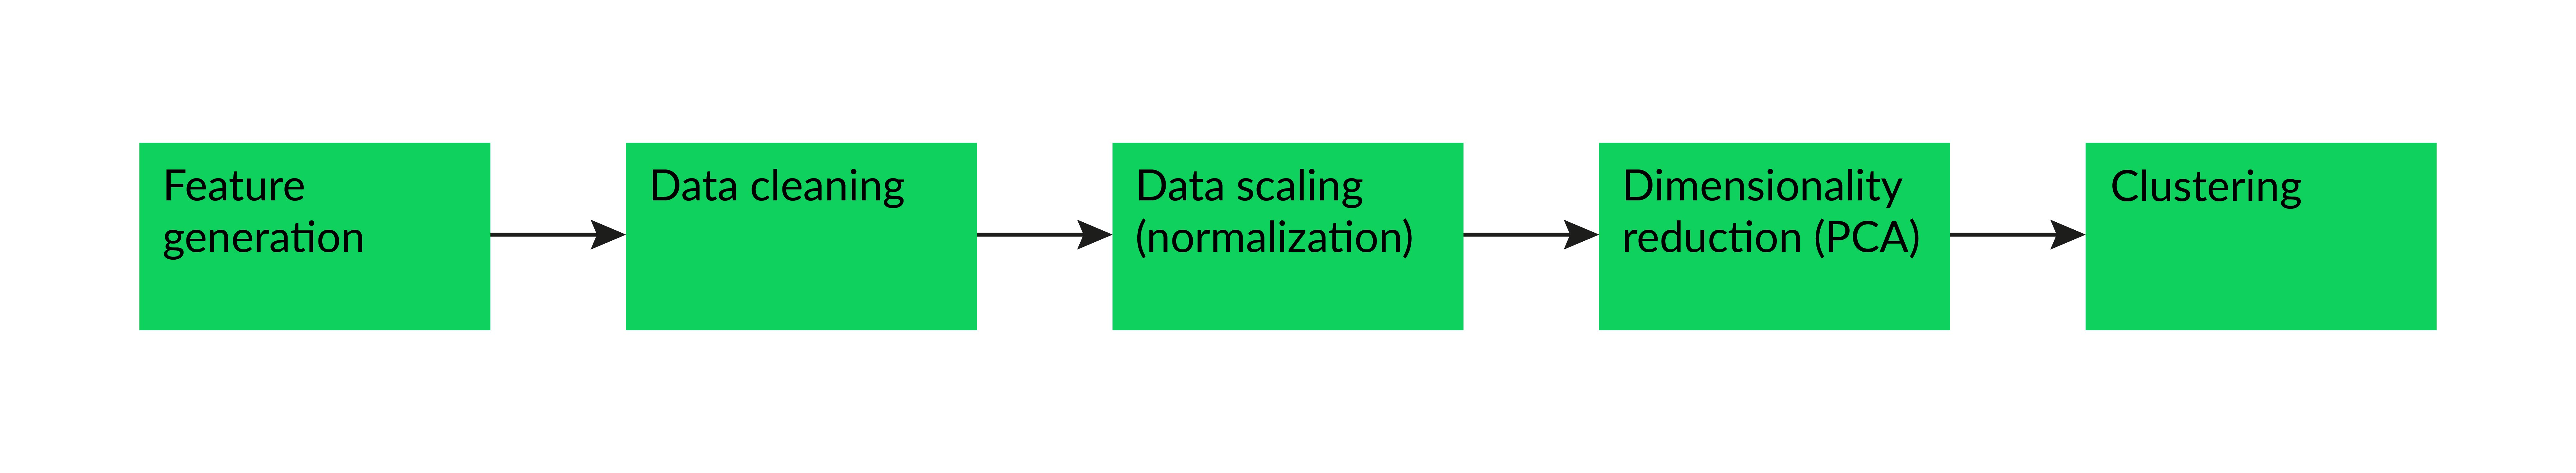

So, we have finished data preprocessing  
In total, we have three dataframes:
* df (with feature generation and data cleaning)  
* df_scaled (scaled version of df)
* df_transform (dimensionality reduction for df_scaled)

## Important:
We will apply clustering algorithms for df_transform, based on this we will get labels for all objects, then we will combine the label column for objects with df in order to get information about clusters (on graphs).

In this work, the following clustering algorithms will be used: (https://scikit-learn.org/stable/modules/clustering.html)
* K-means ++ 
* Aglomerative clustering
* Spectral clustering


It is noteworthy that in these algorithms it is necessary to pre-specify the number of clusters.     
We assume that the minimum number of clusters is two, the maximum number of clusters is eight. Based on this, for different cases of the number of clusters, we will build models.    
If the metric is maximum for models with a large number of clusters, then we will iteratively increase the maximum number of clusters and build new models.


# Now let's build graphs of the main characteristics for features int | float for the best models (since we got object labels)

In [39]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
best_model = AgglomerativeClustering(n_clusters=4)
labels = pd.DataFrame(best_model.fit_predict(df_transform), columns=['Clusters'], index=df.index)
df = pd.concat([df, labels], axis=1)

In [40]:
df.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Clusters'],
      dtype='object')

In [ ]:

num_cols = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [ ]:
def graph_builder():
    """Graphs of the main characteristics for features int | float for the best models.
    The best model was chosen based on the results of the graphs"""
    def boxplot():
        n_cols = len(num_cols)
        rows = n_cols // 3 
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        for num, col in enumerate(num_cols):
            b = sns.boxplot(
                 data=df,
                 y=col,
                 x="Clusters",
                 palette="Paired",
                 ax=axes.reshape(-1)[num])
            b.set_xlabel('Clusters', fontsize=14)
            b.set_ylabel(f'{df[col].name}', fontsize=14)
            sns.set_style('darkgrid')
    
    def histplot():    
        n_cols = len(num_cols)
        rows = n_cols // 3
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        for num, col in enumerate(num_cols):
            h = sns.histplot(
                 data=df,
                 x=col,
                 hue="Clusters",
                 multiple="stack",
                 kde=True,
                 palette="Paired",
                 ax=axes.reshape(-1)[num])
                
            h.set_xlabel(f'{df[col].name}', fontsize=14)
            h.set_ylabel('Count', fontsize=14)
            sns.set_style('darkgrid')
            
 
    
    boxplot()
    histplot()
    
    
graph_builder()